In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp

In [80]:
#Se utiliza la ubicación de los archivos para que el programa los lea
#Se indica cuales son los datos de las fechas

ruta1 = "C:\\Users\\steve\\Desktop\\Mediciones\\Datos Estacionales.xlsx"
df = pd.read_excel(ruta1, sheet_name="Normal", usecols=["Date&Time", "PM2.5"]) #Partículas en suspención de dimensiones
df = df[1:] #Eliminamos la primera fila que contiene los nombres de los datos
df["Date&Time"] = pd.to_datetime(df["Date&Time"])
df = df[df["PM2.5"].apply(lambda x: type(x) == float)] #Filtro para los datos enteros



ruta2 = "C:\\Users\\steve\\Desktop\\Mediciones\\Mediciones.xlsx"
gf = pd.read_excel(ruta2)
gf = gf[1:]
gf["fecha_hora_med"] = pd.to_datetime(gf["fecha_hora_med"])

In [81]:
df["Date&Time"] = pd.to_datetime(df["Date&Time"])
df = df.set_index("Date&Time") #Set datetime Index. 

gf["fecha_hora_med"] = pd.to_datetime(gf["fecha_hora_med"])
gf = gf.set_index("fecha_hora_med")

gf = gf.drop("id_parametro", axis = 1).rename(columns = {"valor": "PM2.5"}) #Cambiar nombre de las columnas

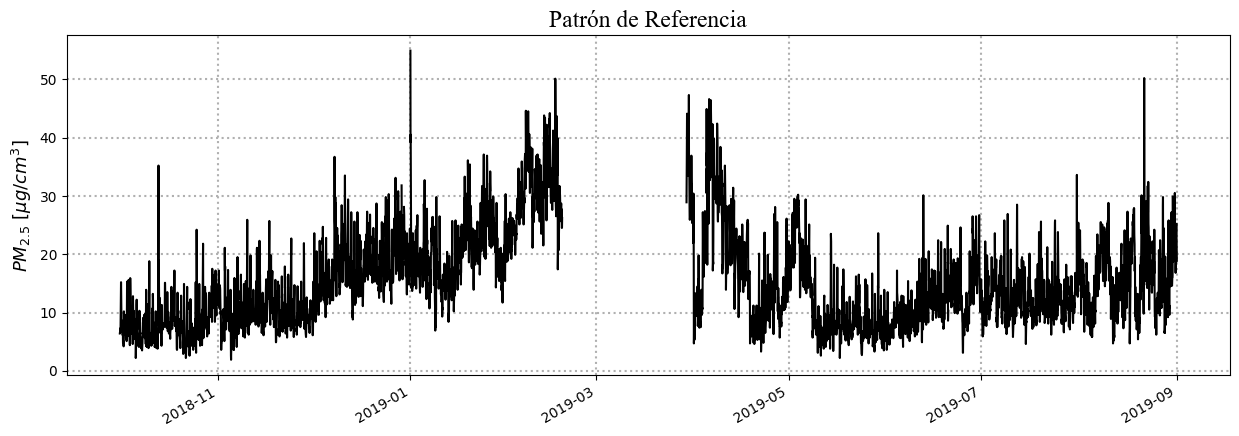

In [82]:
#gráfica de los valores de la columna PM2.5 de df

plt.figure(figsize = (15, 5))
plt.title("Patrón de Referencia", size = 17, fontname = "Times New Roman")

df["PM2.5"].plot(color = "k")
plt.xlabel(None)
plt.ylabel("$PM_{2.5}$ [$\mu g / cm^3$]", size = 13)
plt.grid(linestyle=':', linewidth=1.5)

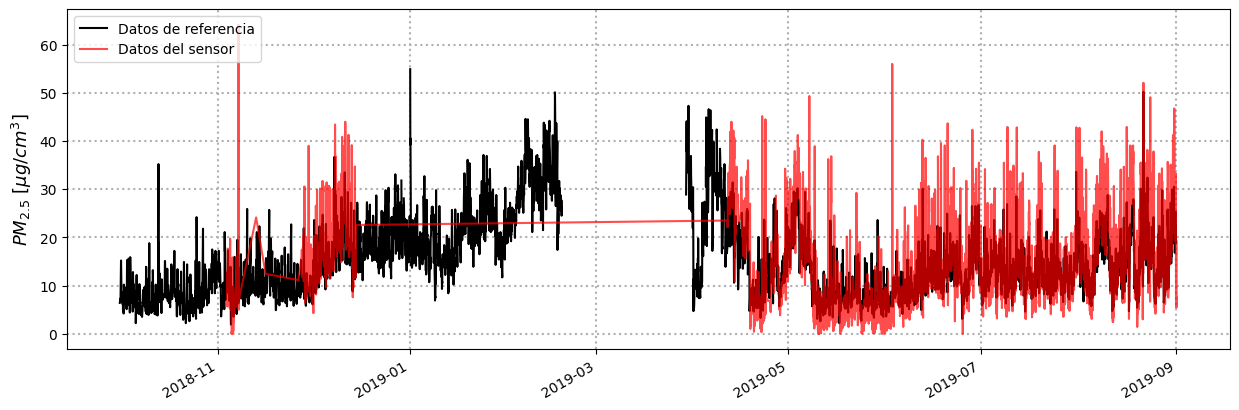

In [83]:
plt.figure(figsize = (15, 5))
df["PM2.5"].plot(color = "k", label = "Datos de referencia")

gf["PM2.5"].plot(color = "red", label = "Datos del sensor", alpha = 0.7)

plt.xlabel(None)
plt.ylabel("$PM_{2.5}$ [$\mu g / cm^3$]", size = 13)
plt.grid(linestyle=':', linewidth=1.5)
plt.legend(loc="upper left")
plt.show()

### Recorte de los datos

In [84]:
#Se agrupan los datos por horas y calcula la media para cada intervalo

ref = df.resample("H").mean() #Ventana Horas
sen = gf.resample("H").mean() 

#Convierte los indices sen y ref para tener formato de fecha y hora
#Covierte los valores de hora al tiempo universal coordinado

ref.index = pd.to_datetime(ref.index).tz_localize('Etc/UCT')
sen.index = pd.to_datetime(sen.index).tz_convert('Etc/UCT') #Hacer que el formato coindicida

In [85]:
#Crea un nuevo DataFrame data con dos columnas de datos "data" y "sen"
#ref["PM2.5"] y sen["PM2.5"] desde marzo de 2019 hasta el final

data = pd.DataFrame({"ref": ref["PM2.5"]["2019-03":], 
                     "sen": sen["PM2.5"]["2019-03":]}, index = sen.index)

data = data.dropna(); data.info() #Elimina las filas con valores faltantes


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2995 entries, 2019-04-11 17:00:00+00:00 to 2019-08-31 22:00:00+00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ref     2995 non-null   object 
 1   sen     2995 non-null   float64
dtypes: float64(1), object(1)
memory usage: 70.2+ KB


In [86]:
def style(xlabel = None, ylabel = "$PM_{2.5}$ [$\mu g / cm^3$]", s = 13):
    
    plt.xlabel(xlabel, size = s)
    plt.ylabel(ylabel, size = s)
    plt.grid(linestyle=':', linewidth=1.5)

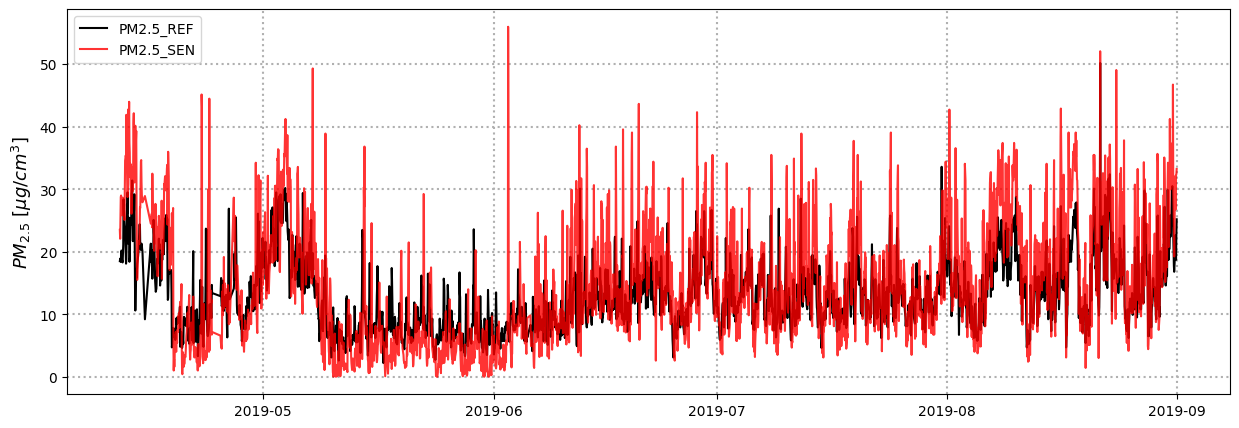

In [87]:
plt.figure(figsize = (15, 5))

plt.plot(data["ref"], "k", label = "PM2.5_REF")
plt.plot(data["sen"], "red", alpha = 0.8, label = "PM2.5_SEN")


style()
plt.legend()

#Los datos del sensor y los de referencias tienen una correlación 
# evidente pero no coinciden del todo, hace falta una calibracion.


In [88]:
from scipy.optimize import curve_fit

#Se utiliza para ajustar una función a datos experimentales mediante el 
# método de mínimos cuadrados no lineales.

units = "[$\mu g / cm^3$]"

Expresión para encontrar un vector u que minimiza la norma de un residuo.

$u = (A^TA)^-1y$

In [89]:
#Se definen las operaciones a realizar

def D(y, y_):
    return np.sqrt(((y - y_)**2).sum())

def linear(x, a, b): #Relación lineal
    return a + b*x

def error(y, y_):
    return D(y, y_) / len(y)

In [90]:
def fit(func,xdata,ydata, 
            r = 2, pop = False, imp = True):
    
    popt, pcov = curve_fit(func, xdata, ydata) 
        
    x = np.linspace(xdata.min(),xdata.max(),100)    
    #Visualización de coeficientes.
    popt, pcov = np.around(popt,r), np.around(np.sqrt(np.diag(pcov)),r)

    mod_fun = func(xdata, *popt)

    E = error(ydata, mod_fun)
            
    if imp:
        print("Coeficients are : {}".format(popt))
        print("Sigma_Coeficients are : {}".format(pcov))
        print("Error on fit is = {} %".format(round(E * 100, r )))
    #visualización de error.   
    
    if pop:
        return popt
    
    return x, func(x, *popt)

In [91]:
pd.DataFrame({"x": data["sen"], "y": data["ref"]}).to_csv("Mediciones.xlsx",index = False)

Coeficients are : [6.9  0.41]
Sigma_Coeficients are : [0.14 0.01]
Error on fit is = 7.44 %
Coeficients are : [6.9  0.41]
Sigma_Coeficients are : [0.14 0.01]
Error on fit is = 7.44 %
El error entre los datos de referencia y los calibrados es 7.44 %


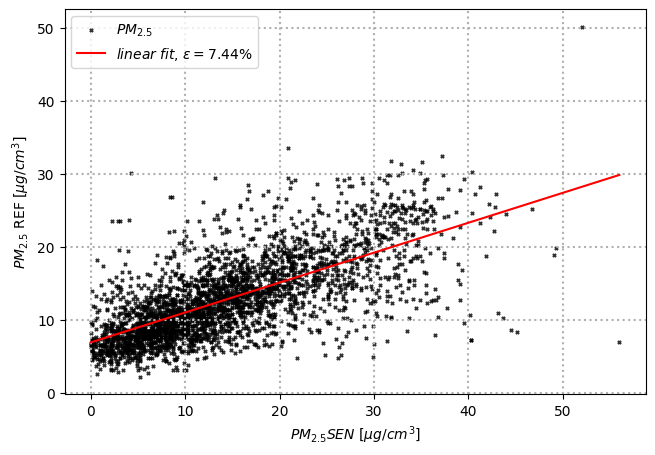

In [92]:
#Una visualización de la relacion entre los datos del sensor y los de referencia. 
plt.figure(figsize = (7.5, 5))

plt.scatter(data["sen"], data["ref"], s = 5, marker = "x", color = "k", alpha = 0.8, label = "$PM_{2.5}$")
plt.plot(*fit(linear, data["sen"], data["ref"]), "r", label = "$linear$ $fit$, $\epsilon = 7.44$%")

#plt.axis("scaled")
style("$PM_{2.5} SEN$ " + units, "$PM_{2.5}$ REF " + units, s = 10)

u_l = fit(linear, data["sen"], data["ref"], pop = True)

E = format(round((error(data["ref"],linear(data["sen"], *u_l)) * 100),2))

print(f"El error entre los datos de referencia y los calibrados es {E} %")

plt.legend()


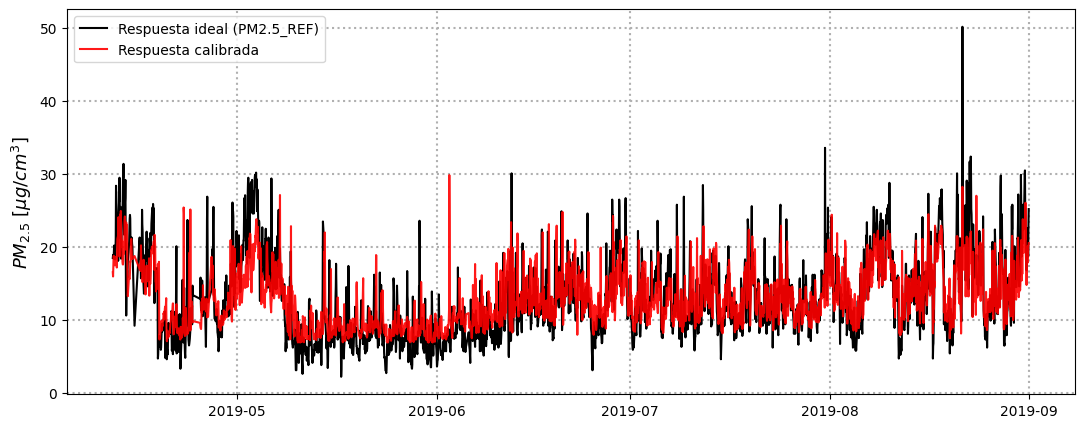

In [93]:
plt.figure(figsize = (13, 5))

plt.plot(data["ref"], "k", label = "Respuesta ideal (PM2.5_REF)") #Datos de referencia
plt.plot(data.index, linear(data["sen"], *u_l), "red", alpha = 0.9, label = "Respuesta calibrada")


style()
plt.legend()

## Con media movil

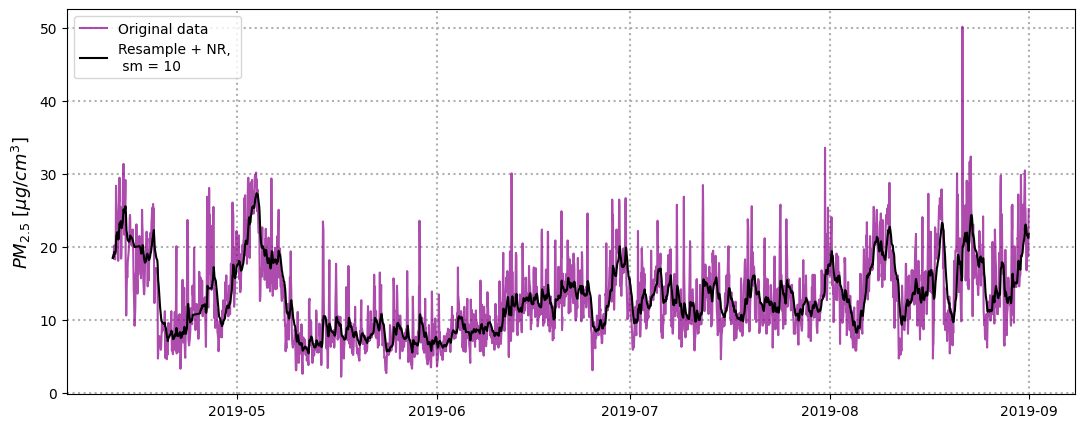

In [94]:
#Se calcula una media móvil exponencial ponderada sobre data

sm = 10
smot = data.ewm(com=sm, adjust=True).mean()

df["PM2.5"].index = df["PM2.5"].index.tz_localize('Etc/UCT')
smot["ref"].index = smot["ref"].index.tz_convert('Etc/UCT')

plt.figure(figsize = (13, 5))
plt.plot(df["PM2.5"][smot.index[0]:], "darkmagenta", alpha = 0.7, label = "Original data")
plt.plot(smot["ref"], "k", label = "Resample + NR, \n sm = {}".format(sm))

style()
plt.legend(loc = "upper left")

In [95]:
days = (data.index[-1] - data.index[0]); days #Datos tomados corersponden a un analisis de 142 días

Timedelta('142 days 05:00:00')

In [96]:
#Define training interval.
m = 2 # Particion de los datos. 
train = smot[: smot.index[0] + days/m]
model = fit(linear, train["sen"], train["ref"])
u_ls = fit(linear, train["sen"], train["ref"], pop = True)

def calibration(xdata, coef = u_ls):
    return linear(xdata, *coef)

Coeficients are : [4.43 0.59]
Sigma_Coeficients are : [0.08 0.01]
Error on fit is = 4.42 %
Coeficients are : [4.43 0.59]
Sigma_Coeficients are : [0.08 0.01]
Error on fit is = 4.42 %


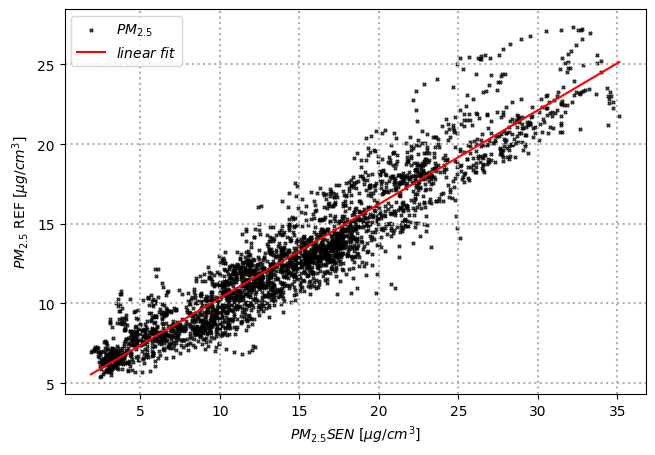

In [97]:
plt.figure(figsize = (7.5, 5))

plt.scatter(smot["sen"], smot["ref"], s = 5, marker = "x", color = "k", alpha = 0.8, label = "$PM_{2.5}$")
plt.plot(*model, "r", label = "$linear$ $fit$")

#plt.axis("scaled")
style("$PM_{2.5} SEN$ " + units, "$PM_{2.5}$ REF " + units, s = 10)

plt.legend()


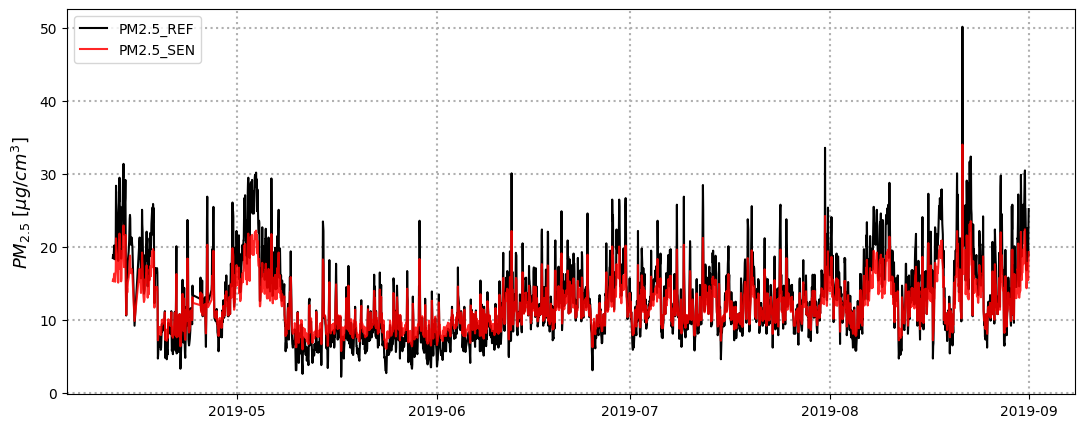

In [98]:
plt.figure(figsize = (13, 5))


plt.plot(data["ref"], "k", alpha = 1, label = "PM2.5_REF")
#plt.plot(smot["data"], "k", label = "PM2.5_REF")
plt.plot(data.index, calibration(data["ref"]), "red", alpha = 0.85, label = "PM2.5_SEN")


style()
plt.legend()